In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

import numpy as np
import matplotlib.pylab as plt

In [2]:
class_names = ['Benign cases', 'Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['Train', 'Test']
    output = []
    
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Loading Train


  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

Loading Test


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 1104.27it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 775
Number of testing examples: 322
Each image is of size: (224, 224)


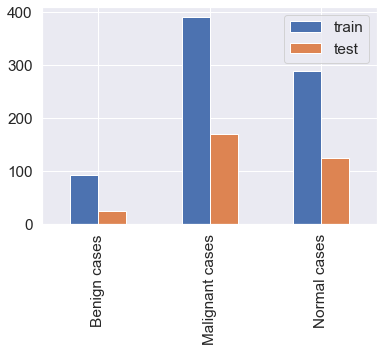

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

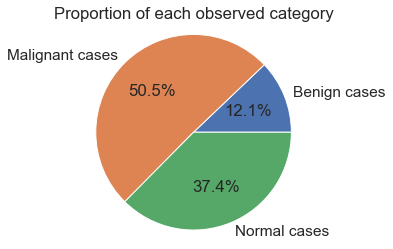

In [8]:
plt.pie(train_counts,
        explode=None , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               11944064  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [12]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=20, validation_split = 0.2)

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 6.8869 - accuracy: 0.4887 - val_loss: 1.0539 - val_accuracy: 0.5226
Epoch 2/20
10/10 [==============================] - 14s 1s/step - loss: 1.0233 - accuracy: 0.5661 - val_loss: 0.9359 - val_accuracy: 0.7032
Epoch 3/20
10/10 [==============================] - 14s 1s/step - loss: 0.7320 - accuracy: 0.7274 - val_loss: 0.5414 - val_accuracy: 0.7806
Epoch 4/20
10/10 [==============================] - 14s 1s/step - loss: 0.3582 - accuracy: 0.8629 - val_loss: 0.2807 - val_accuracy: 0.9032
Epoch 5/20
10/10 [==============================] - 14s 1s/step - loss: 0.1409 - accuracy: 0.9629 - val_loss: 0.1898 - val_accuracy: 0.9355
Epoch 6/20
10/10 [==============================] - 15s 1s/step - loss: 0.0782 - accuracy: 0.9742 - val_loss: 0.1203 - val_accuracy: 0.9677
Epoch 7/20
10/10 [==============================] - 9s 860ms/step - loss: 0.0249 - accuracy: 0.9984 - val_loss: 0.1021 - val_accuracy: 0.9677
Epoch 8/20
10/10 [

In [14]:
test_loss = model.evaluate(test_images, test_labels)

11/11 [==============================] - 2s 141ms/step - loss: 1.0288 - accuracy: 0.7547


In [15]:
test_loss

[1.028757095336914, 0.7546584010124207]

In [16]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

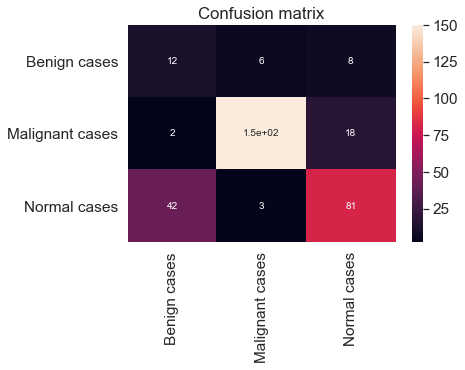

In [17]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [18]:
#Print Classification Report
from sklearn.metrics import classification_report
print('Classification Report')

print(classification_report(test_labels,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.21      0.46      0.29        26
           1       0.94      0.88      0.91       170
           2       0.76      0.64      0.70       126

    accuracy                           0.75       322
   macro avg       0.64      0.66      0.63       322
weighted avg       0.81      0.75      0.78       322



Text(0.5, 1.0, 'Accuracy Curves for CNN model with Processed Dataset')

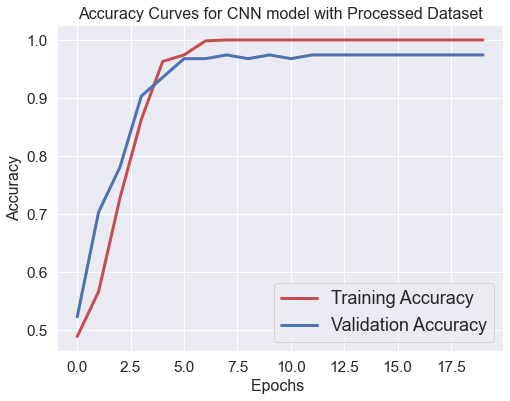

In [19]:
# Accuracy Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves for CNN model with Processed Dataset',fontsize=16)

Text(0.5, 1.0, 'Loss Curves for CNN model with Processed Dataset')

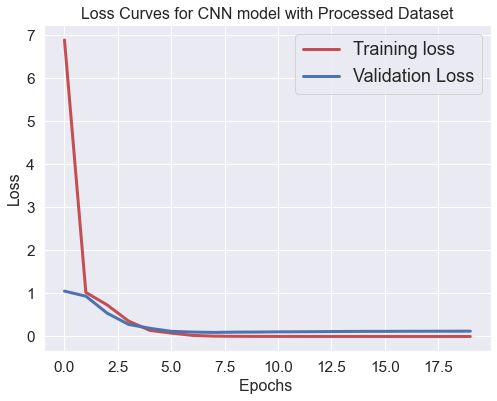

In [20]:
# Loss Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['loss'],'r',linewidth=3.0)

plt.plot(history.history['val_loss'],'b',linewidth=3.0)

plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves for CNN model with Processed Dataset',fontsize=16)